<a href="https://colab.research.google.com/github/SophiaZhuge1/predictive-ML/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

### Exploring Fake News

In [ ]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

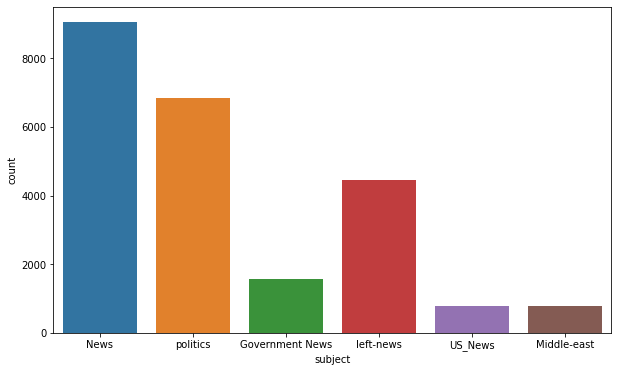

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', data=fake)

### WordCloud
Data Mixing 

In [ ]:
text = ' '.join(fake['text'].tolist()) #joining all text data with a space

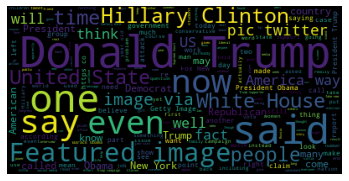

In [ ]:
wordcloud_f = WordCloud().generate(text) 
plt.imshow(wordcloud_f)
plt.axis('off')
plt.show()

### Exploring real news

In [ ]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [ ]:
r_text = ' '.join(real['text'].tolist())

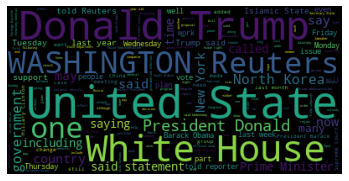

In [ ]:
wordcloud_r = WordCloud().generate(r_text) 
plt.imshow(wordcloud_r)
plt.axis('off')
plt.show()

### Difference in Text

Real news have cources of publication ie. from authority like 'White House' and 'Washington Reuters' which are not present in the the fake data set. 
Some texts are tweets from Twitter.


In [ ]:
real.sample(5)

,title,text,subject,date
3248,Factbox: Review of U.S. national monuments cou...,"(In this June 9 story, corrects name of compa...",politicsNews,"June 10, 2017"
10994,Obama to visit U.S. mosque to counter Republic...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"February 3, 2016"
3644,Trump asked two top intelligence officials to ...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"May 22, 2017"
13764,Reaction to Prince Harry's engagement to Megha...,LONDON (Reuters) - Britain s Prince Harry is e...,worldnews,"November 27, 2017"
625,U.S. attorney general to meet with House intel...,WASHINGTON (Reuters) - U.S. Attorney General J...,politicsNews,"November 15, 2017"


### Data Cleaning

In [ ]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]

    assert(len(record[0]) < 120 )
  except:
    unknown_publishers.append(index)


In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers]

,title,text,subject,date
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
12,Factbox: Trump on Twitter (Dec 28) - Vanity Fa...,The following statements were posted to the ve...,politicsNews,"December 28, 2017"
13,"Trump on Twitter (Dec 27) - Trump, Iraq, Syria",The following statements were posted to the ve...,politicsNews,"December 28, 2017"
14,Man says he delivered manure to Mnuchin to pro...,"(In Dec. 25 story, in second paragraph, corre...",politicsNews,"December 25, 2017"
...,...,...,...,...
20135,China's big money trumps U.S. influence in Cam...,(Story corrects to million from billion in pa...,worldnews,"September 11, 2017"
20500,UK publisher rejected request to block academi...,"(This Sept 8 story corrects headline, clarifi...",worldnews,"September 8, 2017"
20667,Rohingya say their village is lost to Myanmar'...,"(Story refiles to add dropped word not , in ...",worldnews,"September 7, 2017"
21246,'Gates of Hell': Iraqi army says fighting near...,(Story corrects third paragraph to show Mosul...,worldnews,"August 29, 2017"


In [ ]:
real = real.drop(8970, axis=0)

In [ ]:
publisher = [] 
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

In [ ]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [ ]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real['text']= real['title'] + " " + real['text']
fake['text']= fake['title'] + " " + fake['text']

In [ ]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

### Preprocessing Text 

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text', 'class']]
fake = fake[['text', 'class']]

In [ ]:
data = real.append(fake, ignore_index=True)

In [ ]:
data.sample(5)

,text,class
31444,#houston we have a problem! while houston mayo...,0
43291,update: 40% of victim’s skull is missing…no ne...,0
20726,"hurricane irma kills three in puerto rico, gov...",1
36213,hispanic activists promise to punish donald tr...,0
8802,race for u.s. senate seat in indiana shaken up...,1


In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
#!pip install git+https://github.com/laximerit/preprocess_kgptalkie.git --upgrade --force-reinstall


In [ ]:
data['text'] = data['text'].apply(lambda x: (re.sub('[!,*)@#%(&$_?.^]', '', x)))

In [ ]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator: 'let mr mueller ...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


### Vectorisation - Word2Vec
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. Word embedding is the most popular representation of document vocabulary. It is cabable of capturing context of a word in a document semantic and syntactic similarity, relation with other words etc. 

In [ ]:
import gensim

In [ ]:
y = data['class'].values

In [ ]:
X = [d.split() for d in data['text'].tolist()]

In [ ]:
type(X[0])

list

In [ ]:
DIM = 100 #dimension of data - each word will be converted into a sequence of 100 vectors
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)


274859

In [ ]:
w2v_model.wv.most_similar('love') # similar dimension

[('applaud', 0.781958818435669),
 ('thank', 0.7070037722587585),
 ('appreciate', 0.6949024200439453),
 ('admire', 0.66831374168396),
 ('wish', 0.667328953742981),
 ('beautiful', 0.6436948180198669),
 ('bless', 0.63755202293396),
 ('forgive', 0.6364023685455322),
 ('wonderful', 0.636139988899231),
 ('pray', 0.6359757781028748)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
#tokenizer.word_index

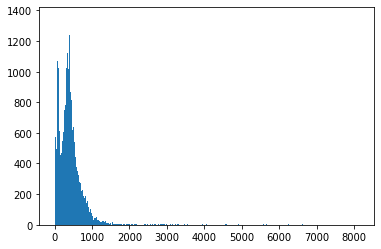

In [ ]:
plt.hist([len(x) for x in X], bins = 700) #number of words in all news articles
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1593

In [ ]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen) #Truncate

In [ ]:
len(X[9])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matirx(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [ ]:
embedding_vectors = get_weight_matirx(w2v_model)

In [ ]:
embedding_vectors.shape

(274860, 100)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid')) #only have 2 dimension fake and real so don't need to use softmax or ReLu
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         27486000  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 27,603,377
Trainable params: 117,377
Non-trainable params: 27,486,000
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 70s 86ms/step - loss: 0.1355 - acc: 0.9515 - val_loss: 0.0929 - val_acc: 0.9665
Epoch 2/6
737/737 [==============================] - 61s 83ms/step - loss: 0.0570 - acc: 0.9818 - val_loss: 0.0398 - val_acc: 0.9883
Epoch 3/6
737/737 [==============================] - 61s 83ms/step - loss: 0.0251 - acc: 0.9919 - val_loss: 0.0204 - val_acc: 0.9933
Epoch 4/6
737/737 [==============================] - 44s 60ms/step - loss: 0.0154 - acc: 0.9952 - val_loss: 0.0234 - val_acc: 0.9916
Epoch 5/6
737/737 [==============================] - 43s 58ms/step - loss: 0.0116 - acc: 0.9961 - val_loss: 0.0156 - val_acc: 0.9953
Epoch 6/6
737/737 [==============================] - 49s 67ms/step - loss: 0.0123 - acc: 0.9959 - val_loss: 0.0194 - val_acc: 0.9935


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [ ]:
accuracy_score(y_test, y_pred)

0.9958129175946547

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5986
           1       0.99      1.00      1.00      5239

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



## Using the model to identify real and fake news
1. tokenise the news text
2. pad the text to fit with the model
3. model.predict
4. 1 = real, 0 = fake

In [ ]:
X_test

array([[     0,      0,      0, ...,    497,      6,   1092],
       [  3153,   5407,    634, ...,    370,      4,  38856],
       [     0,      0,      0, ...,     52,      8, 118975],
       ...,
       [     0,      0,      0, ...,  60250,    462,   1990],
       [     0,      0,      0, ..., 263498,    378,   2007],
       [     0,      0,      0, ...,  26094,     15,    439]], dtype=int32)

In [ ]:
x = ["An invasion could start with aerial bombing that would make departures difficult and endanger civilians, the White House said on Friday. Moscow has repeatedly denied any plans to invade Ukraine despite massing more than 100,000 troops near the border. The US statement prompted countries around the world to issue fresh warnings to nationals in Ukraine."]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [ ]:
model.predict(x)

array([[0.9999615]], dtype=float32)

In [ ]:
(model.predict(x) >= 0.5).astype(int)


array([[1]])